In [1]:
import sys
sys.path.append('/home/campbell/yulee/DAMM/new/code/pro')

from funcs6 import *
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
cohort = 'eddy'
ss = 10

In [11]:
tr_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_exp.h5ad'.format(cohort, ss))
te_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_exp.h5ad'.format(cohort, ss))
pretty_printing = np.hstack([tr_exp.var_names, 'size'])

In [4]:
#nc = len(analysisProteins)
batchSize = 128
learnRate = 1e-3
nm = 'student'
rr = 1
rv = 10 #1000 
r = 0

In [12]:
## compute training and test set
#trY, trS = prepData(tr_exp, 1, analysisProteins) ## inc cell sizes
#teY, teS = prepData(te_exp, 1, analysisProteins) ## inc cell sizes

trY, trS = prepData(tr_exp, 1) ## inc cell sizes
teY, teS = prepData(te_exp, 1) ## inc cell sizes

trFY, trFS, trFL = simulate_data(trY, trS, 1) ## relax rule
teFY, teFS, teFL = simulate_data(teY, teS, 1) ## relax rule

trMat = np.hstack((trY, trS.reshape(-1,1)))
teMat = np.hstack((teY, teS.reshape(-1,1)))
trFMat = np.hstack((trFY, trFS.reshape(-1,1)))
teFMat = np.hstack((teFY, teFS.reshape(-1,1)))
df = ConcatDataset(trY, trS, trFY, trFS, trFL)

In [ ]:
trMat.dtype

# PhenoGraph

In [13]:
#import phenograph
import scanpy.external as sce
pheno_labels, _, _ = sce.tl.phenograph(trMat)
tr_exp.obs['pheno_label'] = pheno_labels.astype(str)

## set number of clusters
nc = len(np.unique(pheno_labels))
pheno_centers = np.zeros((nc, trMat.shape[1]))
for k in range(nc):
    pheno_centers[k,:] = trMat[pheno_labels==k].mean(0)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 6.743012189865112 seconds
Jaccard graph constructed in 1.3160004615783691 seconds
Wrote graph to binary file in 0.3604254722595215 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.810227
After 4 runs, maximum modularity is Q = 0.811772
Louvain completed 24 runs in 8.32248830795288 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 17.085338830947876 seconds


In [14]:
tr_exp.obs['pheno_label'].value_counts()

0     1299
1     1286
2     1132
3      911
4      888
5      787
6      701
7      678
8      529
9      488
10     442
11     296
12     293
13     162
14     108
Name: pheno_label, dtype: int64

In [15]:
nc

15

# FlowSOM

In [16]:
from flowsom import flowsom as flowsom
from sklearn.cluster import AgglomerativeClustering

oPath = '/home/campbell/yulee/DAMM/new/res/{}/{}k/ex1/'.format(cohort, ss)
fs_fn = oPath + 'fsom1t_nc{}_{}_rv{}_rr{}_{}.csv'.format(nc, nm, rv, rr, r)
pd.DataFrame(np.array(trMat), columns = pretty_printing).to_csv(fs_fn)
fsom = flowsom(fs_fn, if_fcs=False, if_drop=True, drop_col=['Unnamed: 0'])

#fn = oPath + 'fsom1.csv'
#fsom = flowsom(fn, if_fcs=False, if_drop=True, drop_col=['Unnamed: 0'])

fsom.som_mapping(50, # x_n: e.g. 100, the dimension of expected map
       50, # y_n: e.g. 100, the dimension of expected map
       fsom.df.shape[1],
       1, # sigma: e.g 1, the standard deviation of initialized weights
       0.5, # lr: e.g 0.5, learning rate
       1000, # batch_size: 1000, iteration times
       tf_str=None, # string, e.g. hlog', None, etc - the transform algorithm
       if_fcs=False # bool, whethe the imput file is fcs file. If not, it should be a csv file
       # seed = 10, for reproducing
      )

start = nc; fsom_nc = 0
while fsom_nc < nc:
    print(nc, start, fsom_nc)
    fsom.meta_clustering(AgglomerativeClustering, min_n=start, max_n=start, verbose=True, iter_n=10) # train the meta clustering for cluster in range(40,45)  

    fsom.labeling()
    #fsom.bestk # the best number of clusters within the range of (min_n, max_n)
    fsom_class = np.unique(fsom.df['category'])
    fsom_nc = len(fsom_class)
    start += 1
    
fsom_labels = np.array(fsom.df['category'])
fsom_sorted_by_count = pd.Series(fsom_labels).value_counts().index

tr_exp.obs['fsom_label'] = 0
for i, val in enumerate(fsom_sorted_by_count):
    idx = fsom_labels == val
    tr_exp.obs['fsom_label'].iloc[idx] = str(i)
    #print(len(tr_exp.obs['fsom_label'].iloc[idx]))
tr_exp.obs['fsom_label'] = tr_exp.obs['fsom_label'].astype(str)

#fsom.meta_clustering(AgglomerativeClustering, min_n=start, max_n=start, verbose=True, iter_n=5)
fsom_centers = np.zeros((max(fsom_class)+1, fsom.df.shape[1]))
for row in range(max(fsom_class)+1):
    fsom_centers[row,:] = fsom.df[fsom_labels==row].mean(0)

fsom_centers = fsom_centers[fsom_sorted_by_count]
fs_centers = fsom_centers[:,:-1]
#pd.DataFrame(fs_centers, columns = fsom.df.columns[:-1])
#pd.DataFrame(out_center, columns = fsom.df.columns[:-1]).to_csv(oName)
#fsom.df['category'].to_csv(oPath + 'fsom{}_label_nc{}.csv'.format(cs, fsom_nc))

Training...
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 8.572777363649442

...ready!
15 15 0
0 samples done...
15 16 12
0 samples done...
15 17 12
0 samples done...
15 18 13
0 samples done...
15 19 14
0 samples done...


/tmp/ipykernel_9285/121609084.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_exp.obs['fsom_label'].iloc[idx] = str(i)


In [17]:
tr_exp.obs['fsom_label'].value_counts()

0     1458
1     1289
2     1251
3     1206
4      869
5      822
6      656
7      628
8      614
9      426
10     232
11     225
12     180
13     104
14      40
Name: fsom_label, dtype: int64

# Random Forest

In [18]:
## run random forest
rf = RandomForestClassifier()
rf.fit(trFMat, trFL)

## save classifiers
#joblib.dump(rf, orf_classifier)

## compute random forest performance of simulated data (confusion matrix)
rf_p_fake_singlet = rf.predict_proba(teFMat)[:,1]
rtn, rfp, rfn, rtp, racc, rf1, rsens, rspec = evalM(rf_p_fake_singlet, teFL)

In [19]:
rf1

0.8377670294236195

# Kmeans Initalization

In [20]:
## damm initialization
Theta0, okms_labels, okms_centers = kmeans_init1(trMat, 1, nc) ## inc cell sizes

## save kmeans results as damm initialization
#torch.save(Theta, output_theta0)

## save kmeans labels (in anndata object)
okms_sorted_by_count = pd.Series(okms_labels).value_counts().index

tr_exp.obs['kms_label'] = 0
for i, val in enumerate(okms_sorted_by_count):
    idx = okms_labels == val
    tr_exp.obs['kms_label'].iloc[idx] = str(i)
    #print(len(tr_exp.obs['fsom_label'].iloc[idx]))
tr_exp.obs['kms_label'] = tr_exp.obs['kms_label'].astype(str)

## save kmeans centers
okms_centers = okms_centers[okms_sorted_by_count]
#pd.DataFrame(okms_centers, columns = pretty_printing).to_csv(ookms_centers)

/tmp/ipykernel_9285/4079753086.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_exp.obs['kms_label'].iloc[idx] = str(i)


In [21]:
tr_exp.obs['kms_label'].value_counts()

0     1394
1     1341
2     1069
3      874
4      868
5      783
6      780
7      504
8      425
9      420
10     382
11     308
12     303
13     290
14     259
Name: kms_label, dtype: int64

## RF on Kmeans

In [15]:
#singlet_indices = np.where(rf.predict_proba(okms_centers)[:,0] <= 0.5)[0]
#Theta1 = {k: v.detach()[singlet_indices].requires_grad_(True) for (k,v) in Theta0.items()}
#Theta1['is_tau'] = Theta1['is_tau'].detach()[:,np.r_[singlet_indices]].requires_grad_(True)

# DAMM

In [22]:
loss, Theta1 = trainWFD(df, rr, Theta0, batchSize, nm, learnRate, rv)

/home/campbell/yulee/DAMM/new/code/pro/funcs6.py:237: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  ccmax = torch.combinations(psi).max(1).values


## Loss Curve

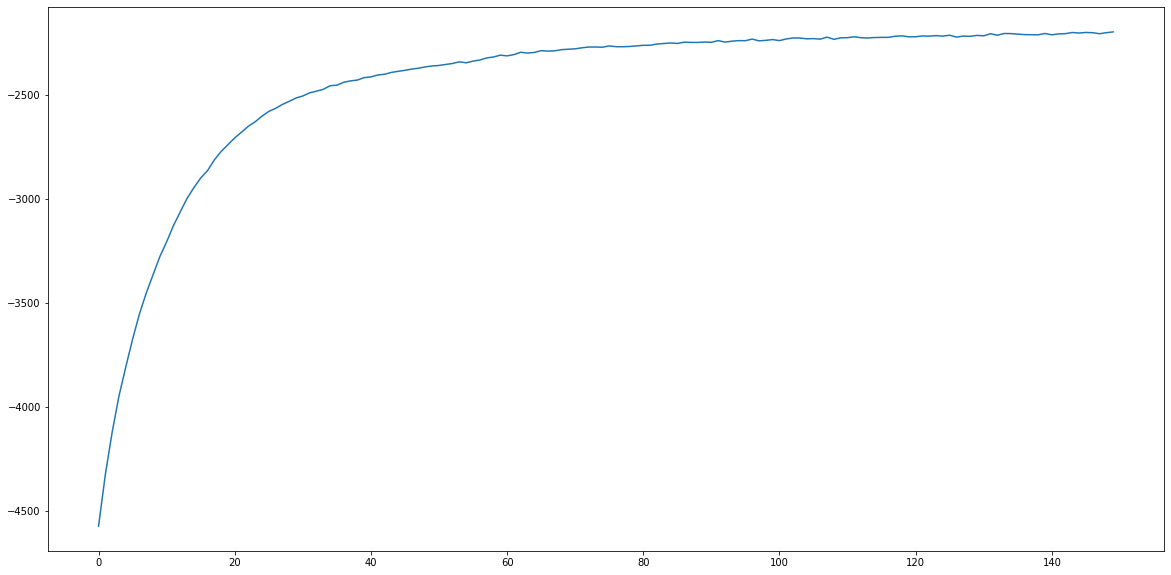

In [27]:
## total loss
plt.plot(np.array(loss)[:,0])

## Label

In [28]:
## output model parameters
#torch.save([loss, Theta], output_theta1)

## damm's doublet performance
with torch.no_grad():
    
    pred_loader = torch.utils.data.DataLoader(ConcatDataset(teFY, teFS), batch_size = 5000, shuffle = False)
    
    damm_p_fake_singlets = []
    for i, bat in enumerate(pred_loader):
        _, _, _ , damm_p_fake_singlet = compute_posteriors_nll_p_singlet(bat[0], bat[1], Theta1, nm, rr)
        damm_p_fake_singlets.append(damm_p_fake_singlet)
        
    ## compute damm performance of simulated data (confusion matrix)
    dtn, dfp, dfn, dtp, dacc, df1, dsens, dspec = evalM(torch.hstack(damm_p_fake_singlets), teFL)
    
    iter_out = [nc, nm, rv, rr, r, 
        rtn, rfp, rfn, rtp, racc, rf1, rsens, rspec,
        dtn, dfp, dfn, dtp, dacc, df1, dsens, dspec]

    ## output doublet performances
    #pd.Series(iter_out).to_csv(odoublet_performance)
    
    ## DAMM label
    damm_pred_singlet_label, damm_pred_singlet_cluster_assig_label, _ = get_assign_labels1(trY, trS, rr, Theta1, nm)    
    damm_sorted_by_count = pd.Series(damm_pred_singlet_cluster_assig_label).value_counts().index
    
    if len(damm_sorted_by_count) != nc:
        damm_sorted_by_count = np.hstack((damm_sorted_by_count, np.setdiff1d(range(nc), damm_sorted_by_count)))
        
    ## save damm labels
    damm_label = np.zeros(trY.shape[0]) + 50
    damm_label[damm_pred_singlet_label == 0] = damm_pred_singlet_cluster_assig_label
    
    #tr_exp.obs['damm_label'] = 50 #len(np.unique(damm_pred_singlet_cluster_assig_label))
    #tr_exp.obs.iloc[np.where(damm_pred_singlet_label == 0)[0],-1] = damm_pred_singlet_cluster_assig_label
    
    ## sorted labels by clusters
    tr_exp.obs['damm_label'] = 50
    for i, val in enumerate(damm_sorted_by_count):
        idx = damm_label == val
        tr_exp.obs['damm_label'].iloc[idx] = str(i)
    tr_exp.obs['damm_label'] = tr_exp.obs['damm_label'].astype(str)

    ## save damm centers
    damm_centers = np.array(torch.hstack([Theta1['log_mu'], Theta1['log_psi'].reshape(-1,1)]).exp())
    damm_centers = damm_centers[damm_sorted_by_count]
    #pd.DataFrame(damm_centers, columns = pretty_printing).to_csv(odamm_centers)

    ## output phenograph/kmeans/damm labels
    #tr_exp.obs.iloc[:,5:].to_csv(olabels)

/tmp/ipykernel_9285/2720189160.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_exp.obs['damm_label'].iloc[idx] = str(i)


In [29]:
tr_exp.obs['damm_label'].value_counts()

0     2791
1     1762
2     1627
3     1514
50    1284
4      563
5      286
6       44
7       36
8       32
9       27
10      19
11       8
12       6
13       1
Name: damm_label, dtype: int64

## Doublet Probability

In [30]:
with torch.no_grad():
    _, _, _, p_singlet = compute_posteriors_nll_p_singlet(trY, trS, Theta1, nm, rr)
tr_exp.obs['prob_doublet'] = 1 - p_singlet

/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pheno_label' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fsom_label' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` pa

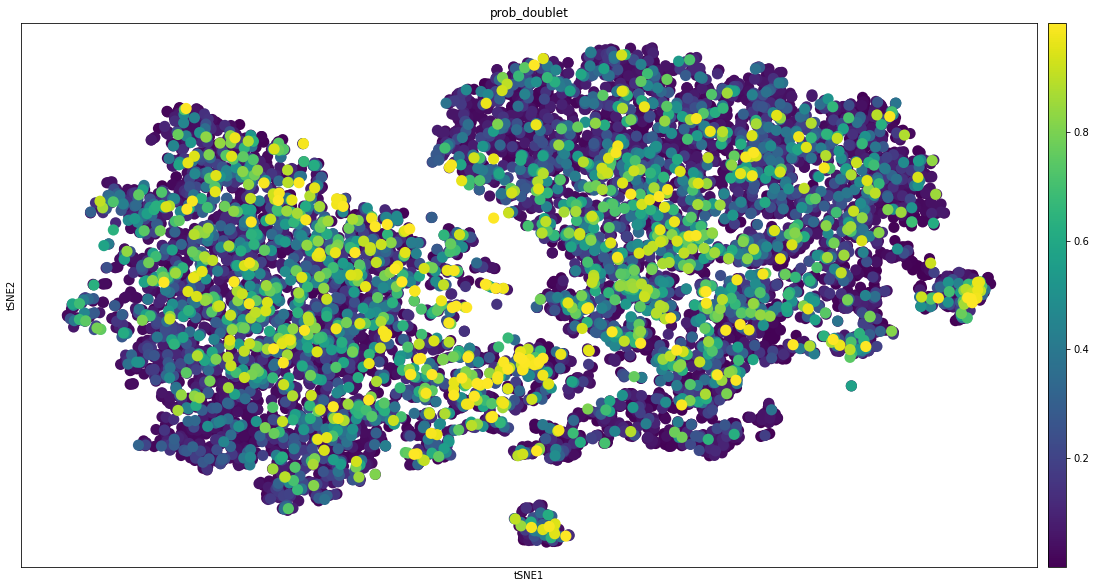

In [31]:
sc.tl.tsne(tr_exp)
sc.pl.tsne(tr_exp, color="prob_doublet", size=500)

In [22]:
## compute neighbors for tsne
#sc.pp.scale(tr_exp, max_value=3)
#sc.tl.pca(tr_exp)
#sc.pp.neighbors(tr_exp, use_rep="X_pca")
#sc.tl.tsne(tr_exp)
#sc.pl.tsne(tr_exp, color="prob_doublet", size=500)

In [32]:
sum(p_singlet.detach() > 0.5)

tensor(8716)

In [33]:
pd.DataFrame(pheno_centers, columns = pretty_printing)

,Stroma,PDL1,CD68,MHCII,CD28,RFP,ICOS,YAP,CD19,HA,...,CD49b,CCR7,CD11b,S100A8-9,DNA1,DNA3,CD45,PNAd,CD31,size
0,6.295035,2.811673,0.662146,0.228234,0.834687,5.174717,0.287352,0.755653,0.363213,0.591727,...,1.663195,4.445020,1.952990,0.145070,12.671741,21.667203,0.769506,0.348639,1.603933,22.225558
1,3.732862,0.946881,0.906450,0.086146,0.438219,1.445073,0.104076,0.539653,0.257437,0.132147,...,0.535056,2.609564,2.084275,0.109056,10.758201,18.421117,0.736518,0.253163,1.735284,26.227061
2,10.293509,4.447155,0.980008,0.258804,0.810251,5.414704,0.309701,0.814225,0.395781,0.546385,...,1.653217,4.487672,2.095838,0.147210,10.796039,18.447998,0.697826,0.365658,1.556925,35.706714
3,3.889571,1.285583,1.127759,0.103322,0.364223,1.796549,0.125862,0.695379,0.723917,0.205413,...,0.732096,2.053773,2.411835,0.120069,10.959688,18.661974,0.671068,0.366663,1.711621,14.406147
4,6.591309,2.898951,0.793446,0.244967,0.888058,5.564023,0.311105,0.750049,0.436405,0.604428,...,1.708965,4.395426,2.025904,0.151903,13.167833,22.461020,0.794792,0.414271,1.643422,45.998874
5,3.825679,1.055472,0.584060,0.087415,0.476804,1.398533,0.097754,0.400623,0.224323,0.125587,...,0.440187,3.036224,2.056939,0.109559,10.694012,18.519202,0.769768,0.234934,1.665549,37.569250
6,9.902220,4.743200,1.209614,0.271501,0.857767,5.657573,0.321933,0.858575,0.493506,0.565306,...,1.699135,4.491565,2.211031,0.154949,11.137466,19.069195,0.720774,0.473202,1.587211,64.550642
7,3.745504,1.065144,0.818824,0.091336,0.488095,1.450551,0.100312,0.430604,0.233912,0.132373,...,0.446078,2.920878,2.166378,0.111840,10.806016,18.559999,0.774262,0.249341,1.683268,48.510324
8,3.733118,1.328426,0.761910,0.113066,0.325409,2.504315,0.162800,0.876554,1.529698,0.315959,...,1.054141,1.279433,2.190143,0.114843,12.816809,21.722574,0.675465,0.529666,1.768944,31.638941
9,3.888570,1.060640,0.787184,0.089370,0.417098,1.549309,0.106652,0.667705,0.474596,0.135812,...,0.664949,2.268935,2.659445,0.128202,10.596244,18.097154,0.722233,0.266332,1.879545,61.342213


In [34]:
pd.DataFrame(fs_centers, columns = fsom.df.columns[:-1])

,Stroma,PDL1,CD68,MHCII,CD28,RFP,ICOS,YAP,CD19,HA,...,CD49b,CCR7,CD11b,S100A8-9,DNA1,DNA3,CD45,PNAd,CD31,size
0,3.744483,1.181303,0.638219,0.101297,0.489079,1.925164,0.126458,0.506322,0.273968,0.201333,...,0.650953,2.845029,1.888985,0.106201,11.055388,18.898916,0.736643,0.269636,1.650803,27.714678
1,3.918013,1.089093,0.818370,0.095154,0.469490,1.677808,0.110663,0.581506,0.316996,0.159240,...,0.629310,2.695183,2.473611,0.127906,10.638196,18.283037,0.743703,0.328122,1.759608,44.767261
2,6.368599,2.974423,0.718219,0.238798,0.850002,5.219365,0.294549,0.706352,0.400646,0.582503,...,1.647705,4.372104,1.985501,0.146687,12.587353,21.482868,0.767933,0.377645,1.590953,36.629097
3,3.878027,1.171355,1.048984,0.104393,0.343825,1.983734,0.134225,0.793162,1.083857,0.223684,...,0.898152,1.594841,2.665364,0.131180,11.396344,19.476961,0.670997,0.467350,1.838677,33.514925
4,3.880535,1.171286,0.910744,0.092786,0.359554,1.735131,0.123800,0.733569,0.674943,0.193655,...,0.752121,2.107492,2.293896,0.117882,11.156463,19.152238,0.669934,0.432801,1.754062,15.008055
5,6.674143,2.955627,0.697747,0.234445,0.847848,5.276343,0.284174,0.755524,0.361316,0.598702,...,1.690681,4.608810,2.006195,0.145899,12.797444,21.839121,0.780713,0.361384,1.616593,19.857664
6,6.938721,2.891825,1.125228,0.202249,0.661988,4.342786,0.247589,0.905023,0.781277,0.444605,...,1.468906,3.201713,2.609755,0.155312,12.060250,20.584246,0.716661,0.728672,1.787224,76.196646
7,4.009468,1.217491,0.828695,0.098308,0.436034,1.748772,0.118318,0.671153,0.494055,0.160528,...,0.712627,2.391192,2.603310,0.125886,10.579624,18.095664,0.720695,0.385082,1.841080,60.866242
8,8.907366,4.433141,1.067757,0.256809,0.848943,5.639688,0.326130,0.837294,0.419342,0.546967,...,1.693555,4.619528,2.181293,0.152727,10.613189,18.187952,0.730863,0.487245,1.614270,52.412052
9,17.604649,5.995376,1.467580,0.310060,0.811461,5.993081,0.356757,1.018228,0.491411,0.552029,...,1.758624,4.676403,2.434387,0.165788,9.752635,16.703586,0.644386,0.570024,1.608005,35.638498


In [35]:
pd.DataFrame(okms_centers, columns = pretty_printing)

,Stroma,PDL1,CD68,MHCII,CD28,RFP,ICOS,YAP,CD19,HA,...,CD49b,CCR7,CD11b,S100A8-9,DNA1,DNA3,CD45,PNAd,CD31,size
0,3.769745,1.029675,0.784969,0.090636,0.433023,1.589799,0.110041,0.590846,0.405812,0.150150,...,0.631645,2.500598,2.341046,0.119956,10.591841,18.228834,0.728259,0.359594,1.780773,38.020086
1,3.923952,1.146483,0.831608,0.094457,0.435233,1.708663,0.114710,0.612732,0.299150,0.160352,...,0.656990,2.543844,2.242441,0.117570,10.392348,17.789647,0.706562,0.347541,1.745339,26.248137
2,7.352808,3.478143,0.824114,0.233226,0.811489,5.147918,0.290467,0.771003,0.406874,0.557500,...,1.654647,4.354375,1.978277,0.138470,11.424480,19.532655,0.729812,0.448868,1.576332,32.984097
3,4.356945,1.430942,1.130952,0.111677,0.419088,2.088267,0.141905,0.761287,0.472083,0.214847,...,0.841096,2.414416,2.461772,0.130928,10.670391,18.172488,0.690175,0.492968,1.756288,13.291762
4,3.835617,1.103170,0.891106,0.096895,0.453205,1.650783,0.108164,0.597128,0.391694,0.151793,...,0.619447,2.487811,2.592243,0.128601,10.479200,17.987576,0.730527,0.367890,1.781976,50.633641
5,6.983873,3.540969,0.937558,0.242498,0.861226,5.453536,0.308491,0.755379,0.446728,0.560758,...,1.668883,4.309615,2.084720,0.149600,11.515479,19.642369,0.741378,0.418604,1.585732,47.892720
6,6.178095,2.878254,0.612506,0.230529,0.854929,5.205341,0.285409,0.741118,0.355940,0.598332,...,1.657380,4.528687,1.933928,0.143446,12.723881,21.762012,0.770753,0.353011,1.604880,19.441592
7,4.296454,1.294625,0.853113,0.106081,0.414311,2.102240,0.139892,0.854629,0.763404,0.201079,...,0.905322,2.123973,2.743249,0.132602,10.889202,18.582489,0.706432,0.694948,1.955797,65.287698
8,3.660662,1.289843,0.869957,0.112753,0.272769,2.416358,0.164661,0.929305,1.856850,0.333628,...,1.007975,1.006365,2.270269,0.113672,13.609629,23.222764,0.673292,0.709351,1.752695,25.571765
9,8.624788,4.221183,1.042290,0.268823,0.894754,5.821713,0.317422,0.830858,0.480930,0.595901,...,1.763896,4.606541,2.118302,0.154319,12.558670,21.467475,0.768902,0.589406,1.680882,65.007143


In [27]:
#pd.DataFrame(okms_centers[singlet_indices], columns = pretty_printing)

In [36]:
pd.DataFrame(damm_centers, columns = pretty_printing)

,Stroma,PDL1,CD68,MHCII,CD28,RFP,ICOS,YAP,CD19,HA,...,CD49b,CCR7,CD11b,S100A8-9,DNA1,DNA3,CD45,PNAd,CD31,size
0,2.856271,0.578306,0.204416,0.058044,0.330821,1.168596,0.076297,0.318016,0.269571,0.107534,...,0.298133,1.650993,1.425325,0.084991,10.613036,18.173956,0.671257,0.211156,1.550579,31.397295
1,5.739503,2.507036,0.352027,0.209876,0.705794,4.538874,0.242003,0.613068,0.302753,0.514234,...,1.411841,3.345692,1.431388,0.113718,11.142464,18.899704,0.613519,0.261841,1.299593,28.831889
2,7.882779,3.455743,0.516440,0.280994,0.965711,6.318660,0.356898,0.768872,0.290535,0.640118,...,1.835962,5.180175,2.128335,0.169306,12.023142,20.455870,0.813780,0.338045,1.710461,29.589456
3,4.263413,1.055497,0.432886,0.099287,0.516829,1.607693,0.110541,0.438351,0.163795,0.126365,...,0.389343,3.178190,2.400770,0.129303,10.607750,18.072909,0.841300,0.248120,1.821631,29.041564
4,4.547952,1.442679,0.339388,0.145984,0.296809,3.954612,0.240761,1.136228,1.697137,0.612883,...,1.689292,0.840651,1.794685,0.106105,11.325880,19.202829,0.541832,0.401497,1.368159,33.528300
5,8.423677,2.077885,0.642077,0.258949,0.566411,7.544823,0.356915,1.518577,1.395762,0.564249,...,2.441875,1.463410,2.157529,0.120438,10.203291,17.145057,0.742324,1.297374,2.102575,34.087417
6,5.635176,3.773377,0.793960,0.217737,0.730877,5.035036,0.263018,0.661301,0.279767,0.589785,...,1.661358,4.485036,1.776918,0.168074,12.071508,21.744873,0.793234,0.279336,1.557855,66.553812
7,4.740675,1.119882,0.400896,0.103104,0.180671,2.070338,0.133736,2.181791,0.595630,0.196434,...,1.577508,1.129279,2.604310,0.201313,8.977436,13.627474,0.521952,0.495092,3.084684,115.370081
8,14.906196,3.387568,0.887597,0.208638,0.502869,11.308057,0.615714,3.537628,1.173323,0.640593,...,4.884471,1.845771,3.004423,0.190983,9.509162,16.871432,0.561100,9.206832,3.525486,36.146463
9,12.596501,4.629156,0.817358,0.266845,0.937129,5.795360,0.373352,1.163761,0.412997,0.517512,...,1.713821,5.956815,2.854955,0.142558,10.143369,17.568849,0.640864,0.409119,1.664572,69.028207


# Expression Heatmap (scaled)

In [37]:
scaler = MinMaxScaler()
#s2 = scaler.fit(np.vstack([pheno_centers, fsom_centers, okms_centers, okms_centers[singlet_indices], damm_centers]))
s2 = scaler.fit(np.vstack([pheno_centers, fs_centers, okms_centers, damm_centers]))

#s2 = scaler.fit(np.vstack([pheno_centers, fs_centers, damm_centers]))

## PhenoGraph

Text(156.0, 0.5, 'Cluster')

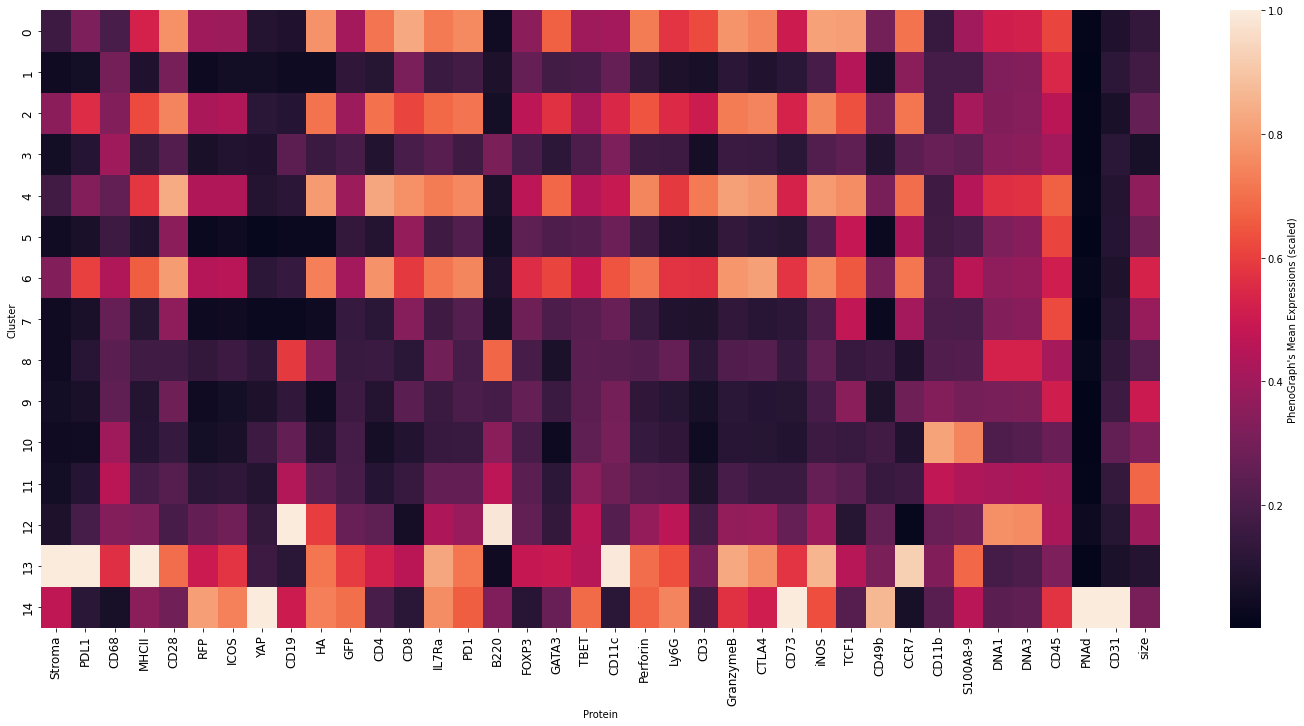

In [38]:
s3 = scaler.transform(pheno_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "PhenoGraph's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [39]:
rf.predict_proba(pheno_centers)[:,0]

array([0.29, 0.48, 0.41, 0.44, 0.55, 0.42, 0.92, 0.87, 0.82, 0.99, 0.74,
       0.99, 0.8 , 0.32, 0.33])

## FlowSOM

Text(156.0, 0.5, 'Cluster')

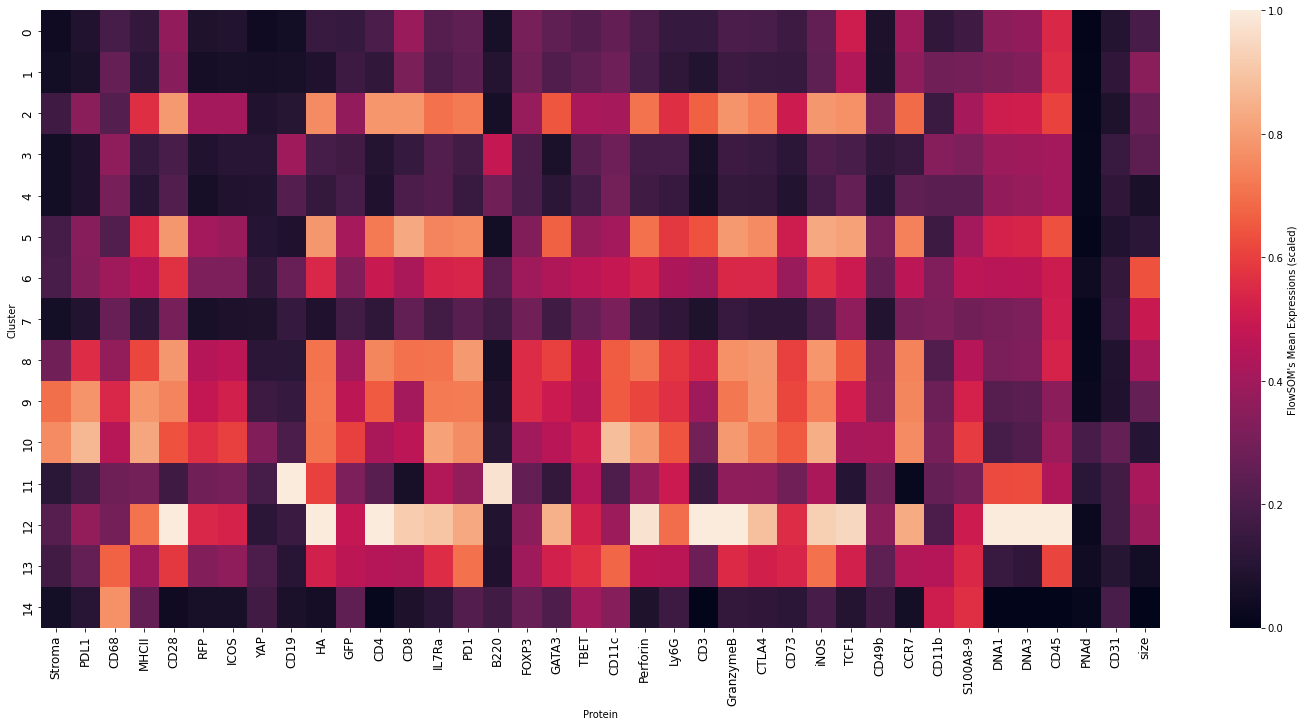

In [40]:
s3 = scaler.transform(fs_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "FlowSOM's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [41]:
rf.predict_proba(fs_centers)[:,0]

array([0.72, 0.85, 0.39, 0.83, 0.42, 0.27, 1.  , 0.97, 0.83, 0.39, 0.35,
       0.83, 0.45, 0.56, 0.31])

## Kmeans

Text(156.0, 0.5, 'Cluster')

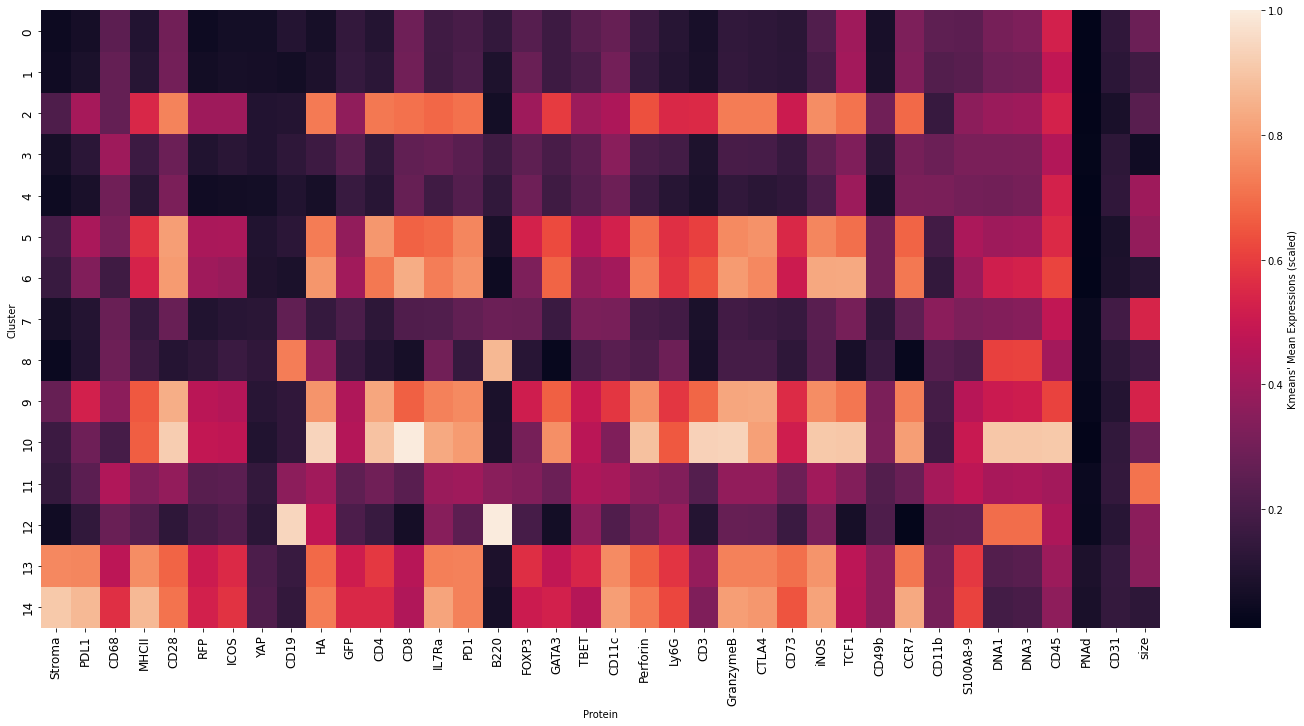

In [42]:
s3 = scaler.transform(okms_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Kmeans' Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [43]:
rf.predict_proba(okms_centers)[:,0]

array([0.71, 0.56, 0.3 , 0.54, 0.94, 0.72, 0.26, 0.95, 0.69, 0.93, 0.43,
       1.  , 0.75, 0.68, 0.29])

# RF on Kmeans

In [36]:
'''
s3 = scaler.transform(okms_centers[singlet_indices])
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "RF on Kmeans' Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")
'''

'\ns3 = scaler.transform(okms_centers[singlet_indices])\nmat = pd.DataFrame(s3, columns = pretty_printing)\nax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={\'label\': "RF on Kmeans\' Mean Expressions (scaled)"})\nax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = \'center\')\nax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = \'center\')\nax.figure.tight_layout()\nplt.xlabel("Protein")\nplt.ylabel("Cluster")\n'

In [37]:
#rf.predict_proba(okms_centers[singlet_indices])[:,0]

## DAMM

Text(156.0, 0.5, 'Cluster')

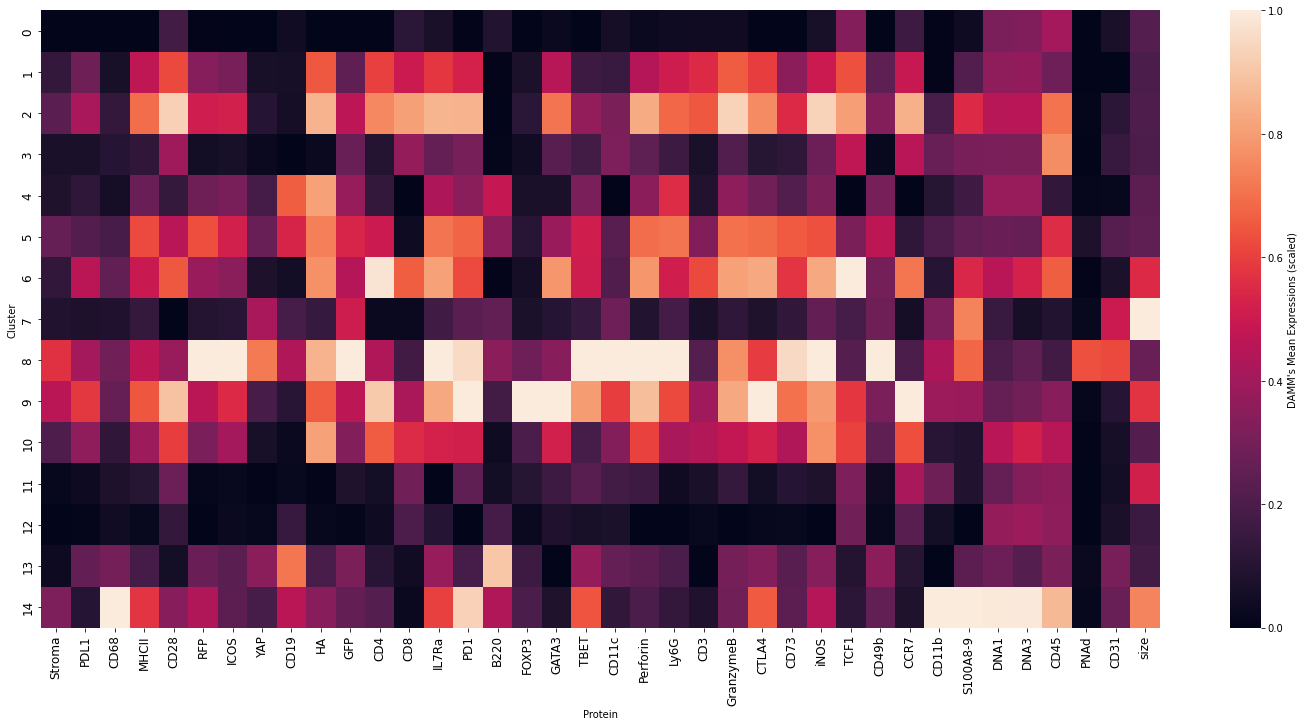

In [44]:
s3 = scaler.transform(damm_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

### Doublet Prob

In [45]:
rf.predict_proba(damm_centers)[:,0]

array([0.38, 0.23, 0.17, 0.29, 0.33, 0.23, 0.84, 0.86, 0.33, 0.84, 0.47,
       0.95, 0.4 , 0.67, 0.91])

# UMAP of PhenoGraph/FlowSOM/Kmeans/DAMM clusters

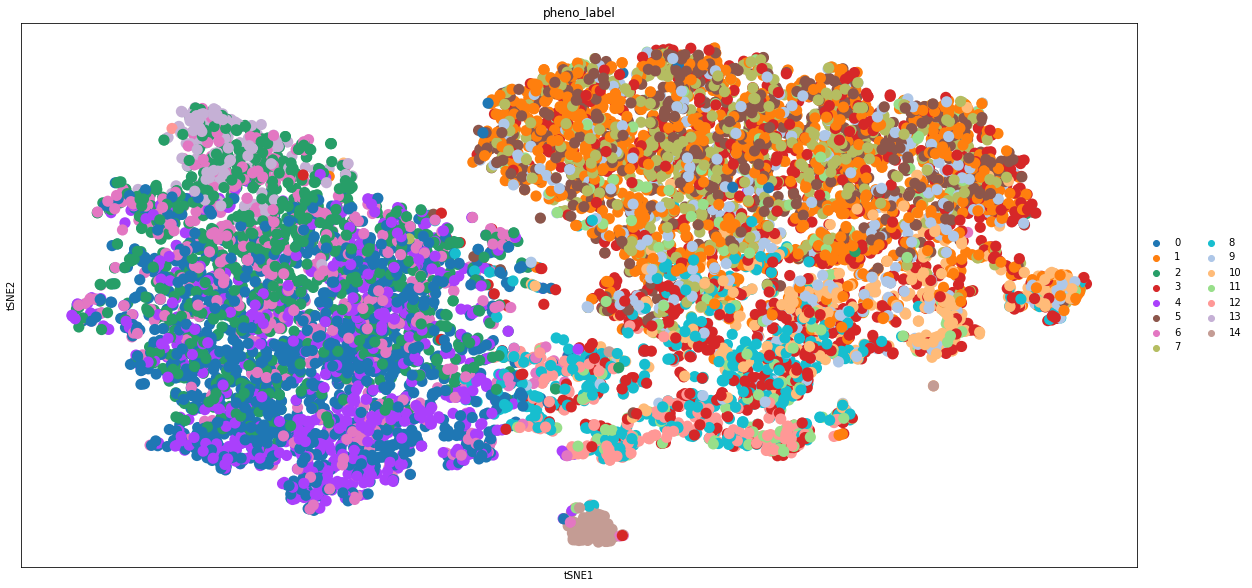

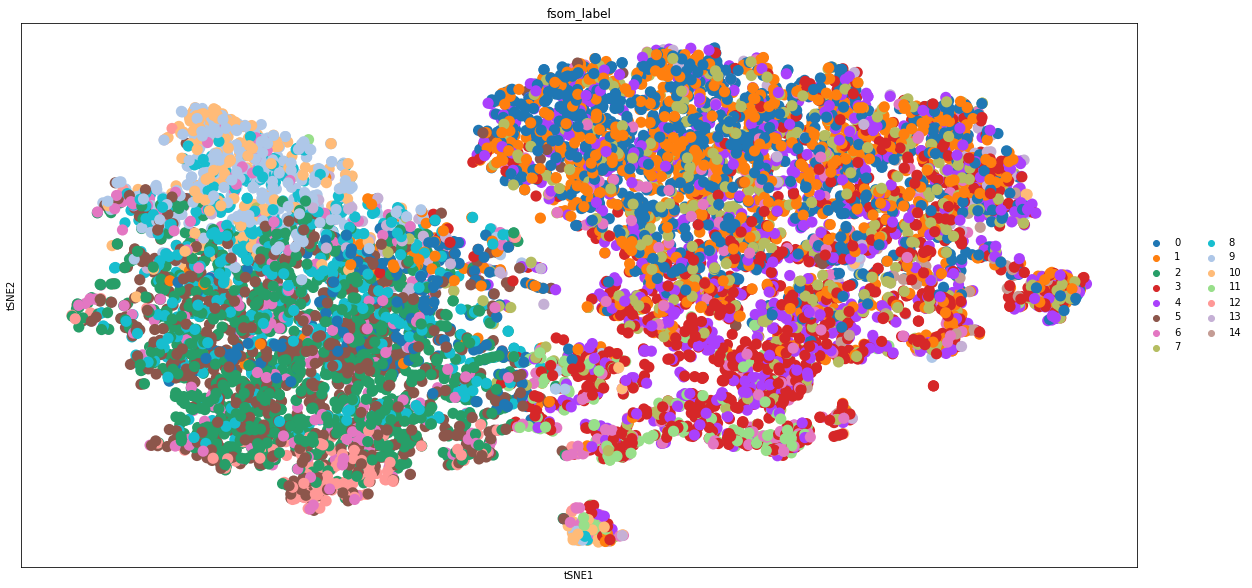

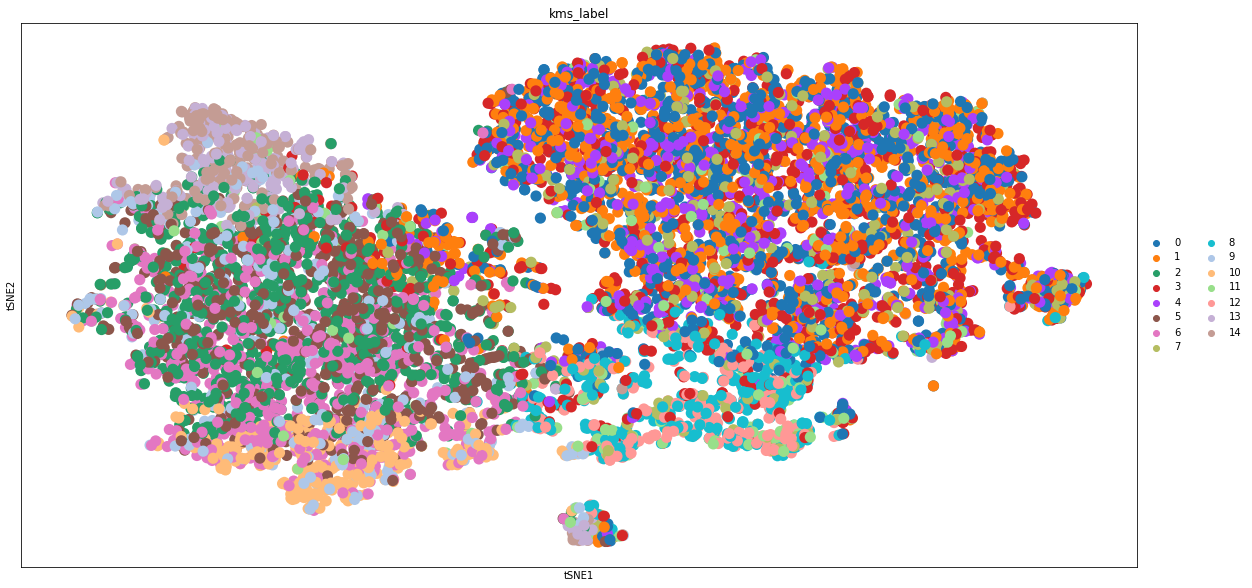

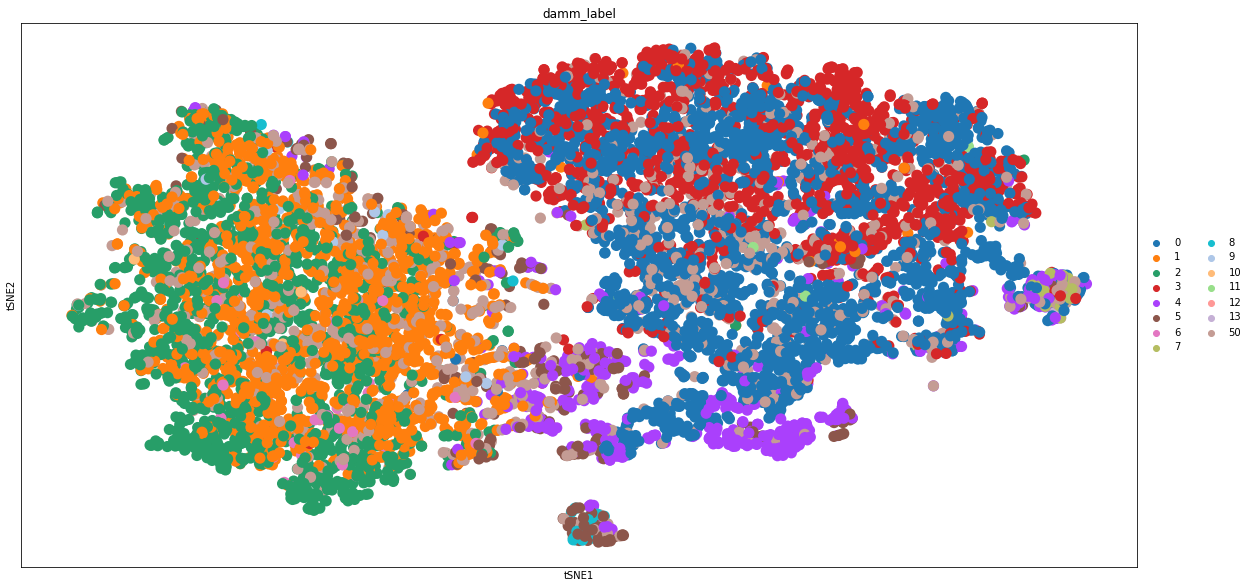

In [46]:
sc.pl.tsne(tr_exp, color="pheno_label", size=500)
sc.pl.tsne(tr_exp, color="fsom_label", size=500)
sc.pl.tsne(tr_exp, color="kms_label", size=500)
sc.pl.tsne(tr_exp, color="damm_label", size=500)

# New Correlation

In [47]:
def newMetric2(mat1, mat2, anti, pairs, thresholds, gp=1):
    out = []
    for pair in pairs:

        x_name = pair[0]; y_name = pair[1]
        #x = np.array(pheno_mat[x_name]); y = np.array(pheno_mat[y_name])
        #x = np.array(damm_mat[x_name]); y = np.array(damm_mat[y_name])
        x1 = np.array(mat1[x_name]); y1 = np.array(mat1[y_name])
        x2 = np.array(mat2[x_name]); y2 = np.array(mat2[y_name])
    
        if anti:
            ## case 1: negative
            score1 = sum((x1 < thresholds[x_name][0]) | (y1 < thresholds[y_name][0]))/len(x1)
            score2 = sum((x2 < thresholds[x_name][0]) | (y2 < thresholds[y_name][0]))/len(x2)
            out.append([x_name + '_' + y_name, score1, score2, 0])
        else:
            ## case 2: positive
            score1 = sum((x1 > thresholds[x_name][1]) | (y1 < thresholds[y_name][0]))/len(x1)
            score2 = sum((x2 > thresholds[x_name][1]) | (y2 < thresholds[y_name][0]))/len(x2)
            out.append([x_name + '_' + y_name, score1, score2, 1])
            
        print("{}_{} -- PG: {}; DAMM: {}".format(x_name, y_name, score1, score2))
        
        '''
        plt.scatter(x1, y1)
        plt.axvline(x=thresholds[x_name][0], color='r')
        plt.axvline(x=thresholds[x_name][1], color='r')    
        plt.axhline(y=thresholds[y_name][0], color='r')
        plt.axhline(y=thresholds[y_name][1], color='r')
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.title("PhenoGraph anti: {}".format(anti))
        plt.show()
        
        plt.scatter(x2, y2)
        plt.axvline(x=thresholds[x_name][0], color='r')
        plt.axvline(x=thresholds[x_name][1], color='r')    
        plt.axhline(y=thresholds[y_name][0], color='r')
        plt.axhline(y=thresholds[y_name][1], color='r')
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.title("DAMM anti: {}".format(anti))
        plt.show()
        '''
    if gp:
        out_col = ['pair', 'PhenoGraph', 'DAMM', 'type']
    else:
        out_col = ['pair', 'FlowSOM', 'DAMM', 'type']
    return pd.DataFrame(out, columns = out_col)

In [49]:
thresholds = pd.DataFrame(np.quantile(tr_exp.X, [0.25, 0.75], axis=0), columns = pretty_printing[:-1])

In [50]:
thresholds

,Stroma,PDL1,CD68,MHCII,CD28,RFP,ICOS,YAP,CD19,HA,...,TCF1,CD49b,CCR7,CD11b,S100A8-9,DNA1,DNA3,CD45,PNAd,CD31
0,3.055556,0.681653,0.200000,0.065217,0.333333,1.314815,0.083333,0.352941,0.162791,0.116667,...,4.041667,0.366667,1.673724,1.342376,0.068182,9.591837,16.535715,0.571429,0.192176,1.365308
1,6.983532,2.844888,0.823728,0.235294,0.785714,5.128412,0.296746,0.846154,0.642857,0.566121,...,8.466666,1.678571,4.300758,2.601163,0.178571,12.731708,21.722701,0.864407,0.375000,1.870968


In [51]:
anti_pairs = [['CD3','CD19'],
              ['CD3','CD68'],
              ['CD4','CD8'],
              ['CD4','CD19'],
              ['CD4','CD68'],
              ['CD8','CD11b'],
              ['CD8','CD19'],
              ['CD8','CD68'],
              ['CD19','CD68']]
    
co_pairs = [['CD3','CD4'],
            ['CD3','CD8'],
            ['CD45','CD3'],
            ['CD45','CD4'],
            ['CD45','CD8'],
            ['CD45','CD19'],
            ['CD45','CD68']]

In [45]:
#!pip install --upgrade matplotlib>=3.3.4

In [52]:
pheno_mat = pd.DataFrame(pheno_centers, columns = pretty_printing)
damm_mat = pd.DataFrame(damm_centers, columns = pretty_printing)
anti = newMetric2(pheno_mat, damm_mat, 1, anti_pairs, thresholds, 1)
co = newMetric2(pheno_mat, damm_mat, 0, co_pairs, thresholds, 1)
df = pd.concat([anti, co])

CD3_CD19 -- PG: 0.06666666666666667; DAMM: 0.2
CD3_CD68 -- PG: 0.06666666666666667; DAMM: 0.2
CD4_CD8 -- PG: 0.06666666666666667; DAMM: 0.3333333333333333
CD4_CD19 -- PG: 0.0; DAMM: 0.0
CD4_CD68 -- PG: 0.0; DAMM: 0.0
CD8_CD11b -- PG: 0.06666666666666667; DAMM: 0.3333333333333333
CD8_CD19 -- PG: 0.06666666666666667; DAMM: 0.3333333333333333
CD8_CD68 -- PG: 0.06666666666666667; DAMM: 0.3333333333333333
CD19_CD68 -- PG: 0.0; DAMM: 0.0
CD3_CD4 -- PG: 0.2; DAMM: 0.2
CD3_CD8 -- PG: 0.26666666666666666; DAMM: 0.5333333333333333
CD45_CD3 -- PG: 0.06666666666666667; DAMM: 0.26666666666666666
CD45_CD4 -- PG: 0.0; DAMM: 0.06666666666666667
CD45_CD8 -- PG: 0.06666666666666667; DAMM: 0.3333333333333333
CD45_CD19 -- PG: 0.0; DAMM: 0.06666666666666667
CD45_CD68 -- PG: 0.0; DAMM: 0.06666666666666667


Text(0.5, 0.98, 'eddy: Correlation Alternative')

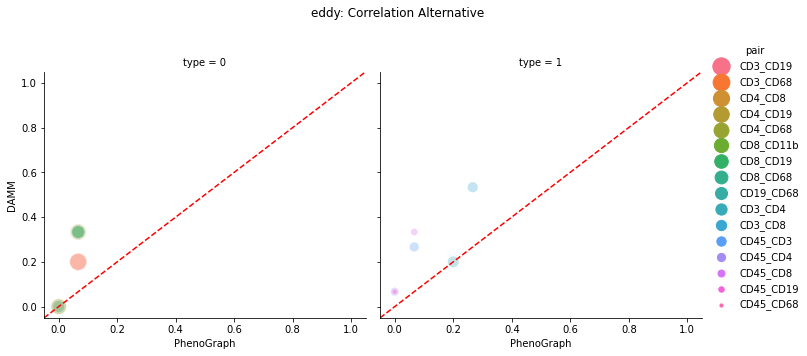

In [53]:
rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair', size="pair", sizes=(10, 300), alpha = 0.3)
#rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair')
for ax in rel.axes_dict.values():
    ax.axline((0, 0), (1,1), ls="--", color ='red')
#rel.data = df  # Hack needed to work around bug on v0.11, fixed in v0.12.dev
#rel.map(sns.lineplot, 'PhenoGraph', 'DAMM')
rel.fig.subplots_adjust(top=.8)
rel.fig.suptitle('{}: Correlation Alternative'.format(cohort))

In [54]:
fs_mat = pd.DataFrame(fs_centers, columns = pretty_printing)
anti = newMetric2(fs_mat, damm_mat, 1, anti_pairs, thresholds, 0)
co = newMetric2(fs_mat, damm_mat, 0, co_pairs, thresholds, 0)
df = pd.concat([anti, co])

CD3_CD19 -- PG: 0.06666666666666667; DAMM: 0.2
CD3_CD68 -- PG: 0.06666666666666667; DAMM: 0.2
CD4_CD8 -- PG: 0.13333333333333333; DAMM: 0.3333333333333333
CD4_CD19 -- PG: 0.0; DAMM: 0.0
CD4_CD68 -- PG: 0.0; DAMM: 0.0
CD8_CD11b -- PG: 0.13333333333333333; DAMM: 0.3333333333333333
CD8_CD19 -- PG: 0.13333333333333333; DAMM: 0.3333333333333333
CD8_CD68 -- PG: 0.13333333333333333; DAMM: 0.3333333333333333
CD19_CD68 -- PG: 0.0; DAMM: 0.0
CD3_CD4 -- PG: 0.26666666666666666; DAMM: 0.2
CD3_CD8 -- PG: 0.4; DAMM: 0.5333333333333333
CD45_CD3 -- PG: 0.13333333333333333; DAMM: 0.26666666666666666
CD45_CD4 -- PG: 0.06666666666666667; DAMM: 0.06666666666666667
CD45_CD8 -- PG: 0.2; DAMM: 0.3333333333333333
CD45_CD19 -- PG: 0.06666666666666667; DAMM: 0.06666666666666667
CD45_CD68 -- PG: 0.06666666666666667; DAMM: 0.06666666666666667


Text(0.5, 0.98, 'eddy: Correlation Alternative')

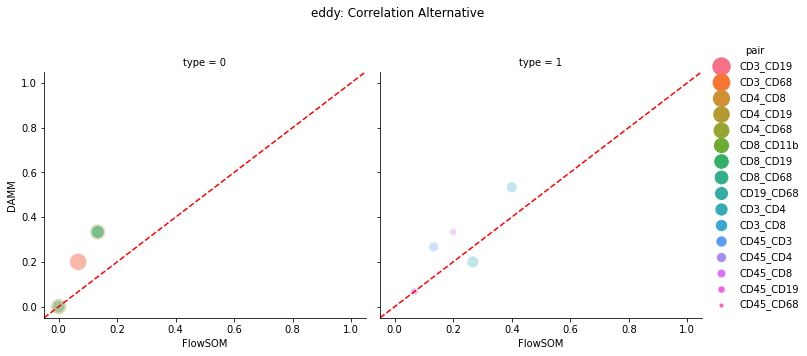

In [55]:
rel = sns.relplot(data=df, x='FlowSOM', y='DAMM', col='type', hue='pair', size="pair", sizes=(10, 300), alpha = 0.3)
#rel = sns.relplot(data=df, x='PhenoGraph', y='DAMM', col='type', hue='pair')
for ax in rel.axes_dict.values():
    ax.axline((0, 0), (1,1), ls="--", color ='red')
#rel.data = df  # Hack needed to work around bug on v0.11, fixed in v0.12.dev
#rel.map(sns.lineplot, 'PhenoGraph', 'DAMM')
rel.fig.subplots_adjust(top=.8)
rel.fig.suptitle('{}: Correlation Alternative'.format(cohort))

# ARS of PhenoGraph/FlowSOM/Kmeans/DAMM

In [56]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['fsom_label'])

0.4304675466047147

In [57]:
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['kms_label'])

0.5131276721529108

In [58]:
adjusted_rand_score(tr_exp.obs['pheno_label'], tr_exp.obs['damm_label'])

0.16915104837568418

In [59]:
adjusted_rand_score(tr_exp.obs['fsom_label'], tr_exp.obs['kms_label'])

0.4263349852551055

In [60]:
adjusted_rand_score(tr_exp.obs['fsom_label'], tr_exp.obs['damm_label'])

0.14724098404604158

In [61]:
adjusted_rand_score(tr_exp.obs['kms_label'], tr_exp.obs['damm_label'])

0.15012139216367862

# Confusion matrix of PG/FS vs DAMM clusters

In [80]:
##remove doublet cells
singlet_set = tr_exp.obs[tr_exp.obs['damm_label'] != '50']

In [81]:
singlet_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8716 entries, ILNd_3535 to ILNd_16461
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sample        8716 non-null   category
 1   id            8716 non-null   int64   
 2   x             8716 non-null   float64 
 3   y             8716 non-null   float64 
 4   area          8716 non-null   int64   
 5   area_convex   8716 non-null   int64   
 6   pheno_label   8716 non-null   object  
 7   fsom_label    8716 non-null   category
 8   kms_label     8716 non-null   category
 9   damm_label    8716 non-null   category
 10  prob_doublet  8716 non-null   float64 
dtypes: category(4), float64(3), int64(3), object(1)
memory usage: 580.9+ KB


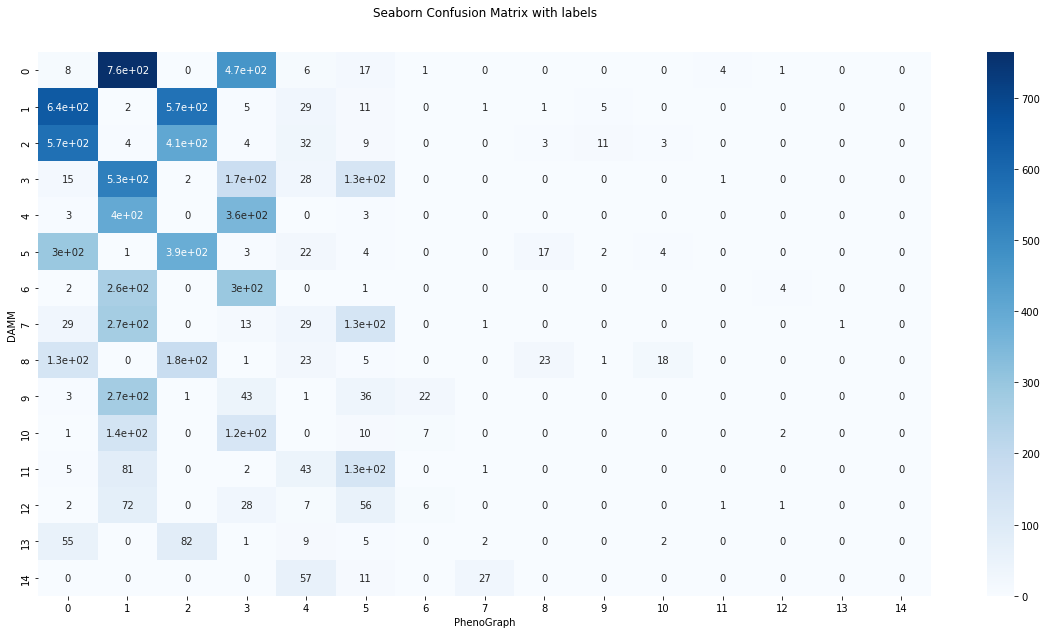

In [92]:
##use singlet cells to compute confusion matrix
cf_mat = confusion_matrix(singlet_set['pheno_label'], singlet_set['damm_label'], labels = singlet_set['pheno_label'].value_counts().index)

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues');

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('PhenoGraph');
ax.set_ylabel('DAMM');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

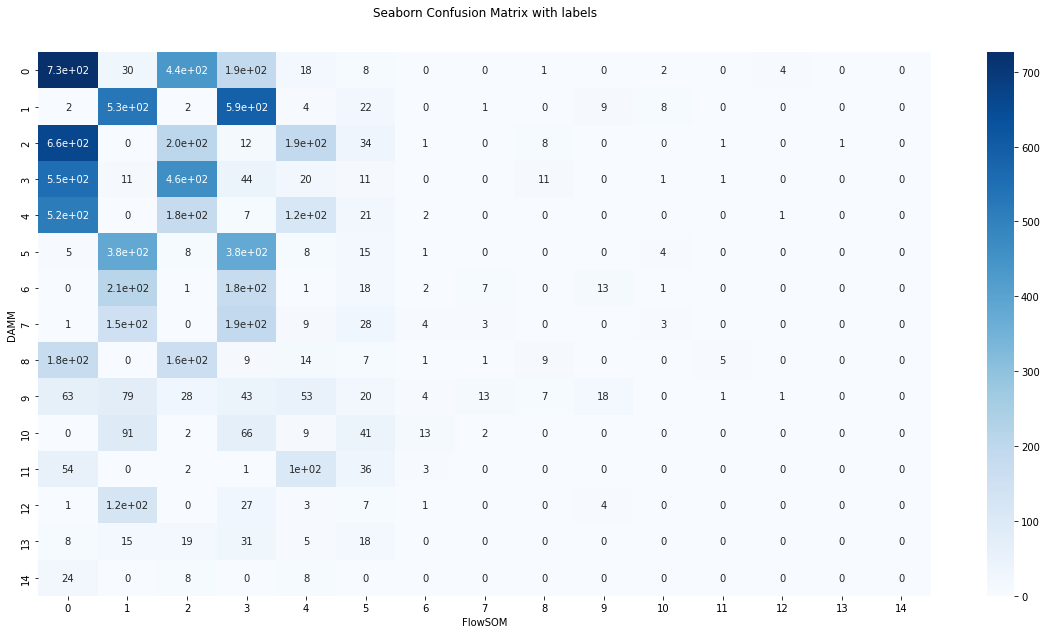

In [93]:
cf_mat = confusion_matrix(singlet_set['fsom_label'], singlet_set['damm_label'], labels = singlet_set['fsom_label'].value_counts().index)

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues');

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('FlowSOM');
ax.set_ylabel('DAMM');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Doublet distribution

In [94]:
doublet_set = tr_exp.obs[tr_exp.obs['damm_label'] == '50']

In [95]:
doublet_set['pheno_label'].value_counts()

6     318
9     206
4     153
11    123
7     119
2      86
10     64
8      54
0      38
3      30
5      29
12     28
1      17
14     13
13      6
Name: pheno_label, dtype: int64

In [96]:
doublet_set['fsom_label'].value_counts()

6     326
7     244
8     182
1     175
3      91
2      85
0      45
9      37
11     26
4      25
5      20
12     12
10      8
13      8
14      0
Name: fsom_label, dtype: int64

# Pinch Effect

In [ ]:
#area of convex hull of cell / area of cell

In [104]:
np.mean(singlet_set['area_convex']/singlet_set['area'])

1.0690417943823254

In [105]:
np.mean(doublet_set['area_convex']/doublet_set['area'])

1.0953949794439315

# Cell sizes by cluster

<AxesSubplot:xlabel='cluster', ylabel='size'>

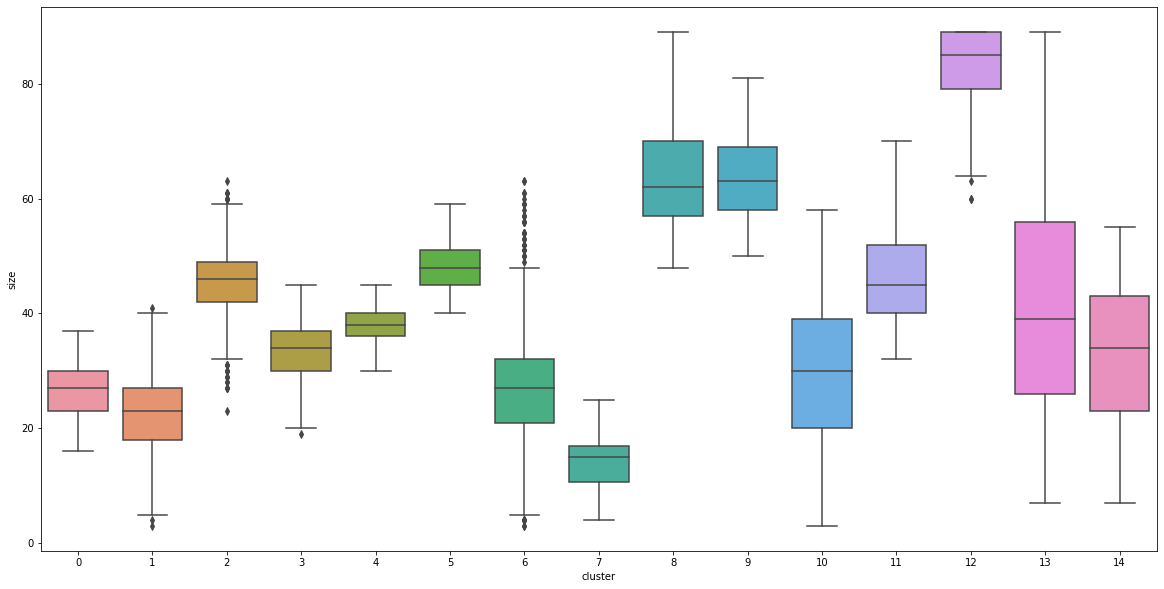

In [65]:
## phenograph
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': pheno_labels})
d3 = d2.merge(d1, on='cluster')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

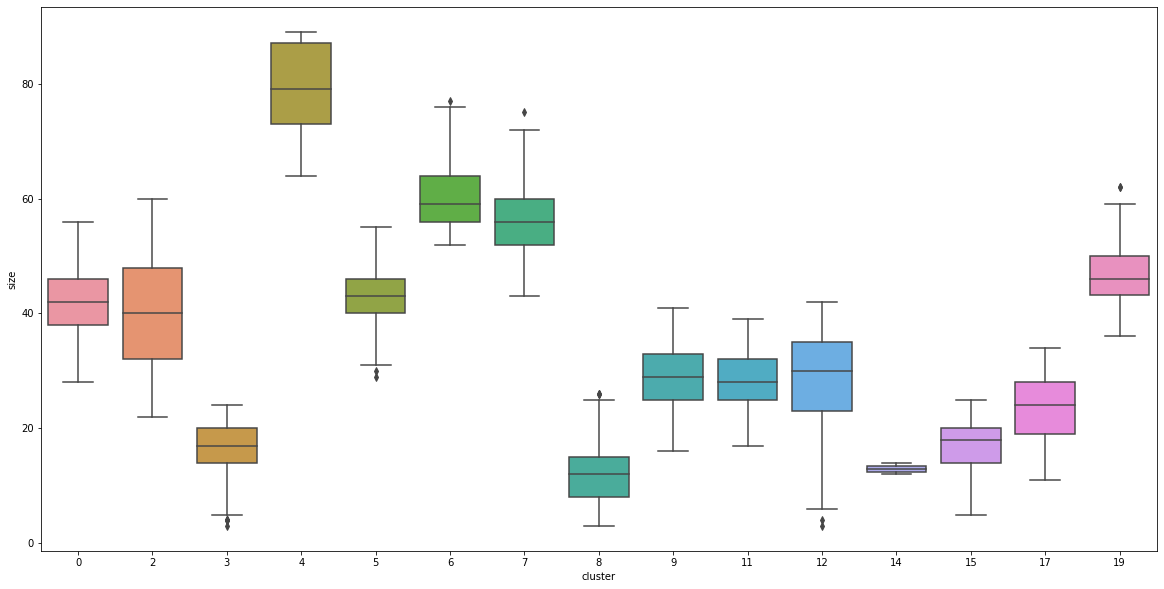

In [66]:
## FlowSOM
d1 = pd.DataFrame({'cluster': fsom_sorted_by_count, 'psi': fs_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': fsom_labels})
d3 = d2.merge(d1, on='cluster')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

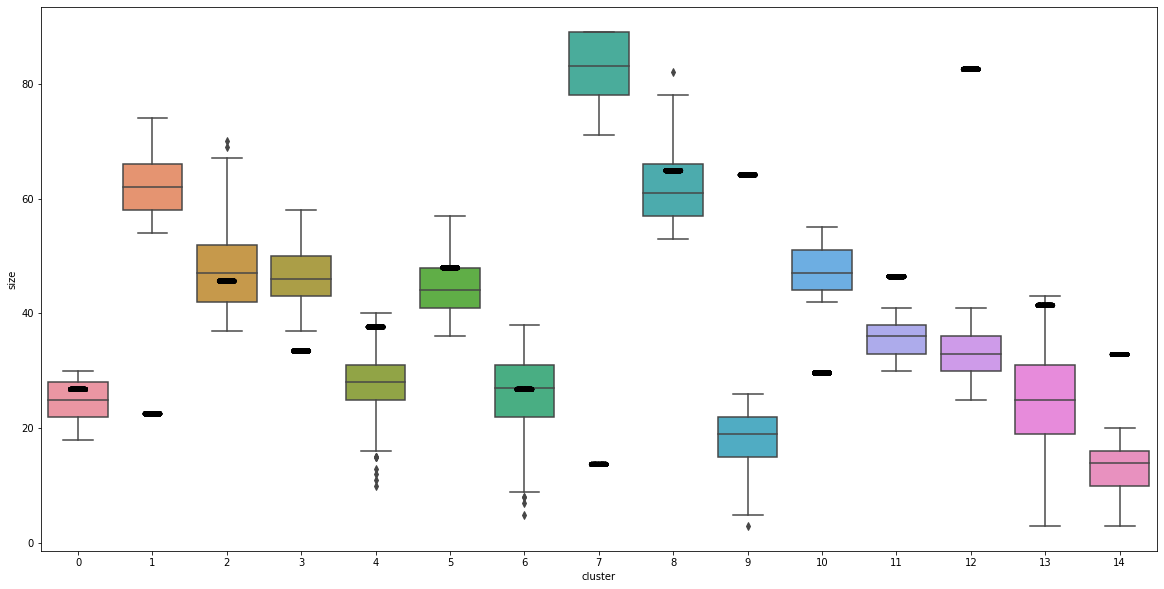

In [67]:
## kmeans
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': okms_labels})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

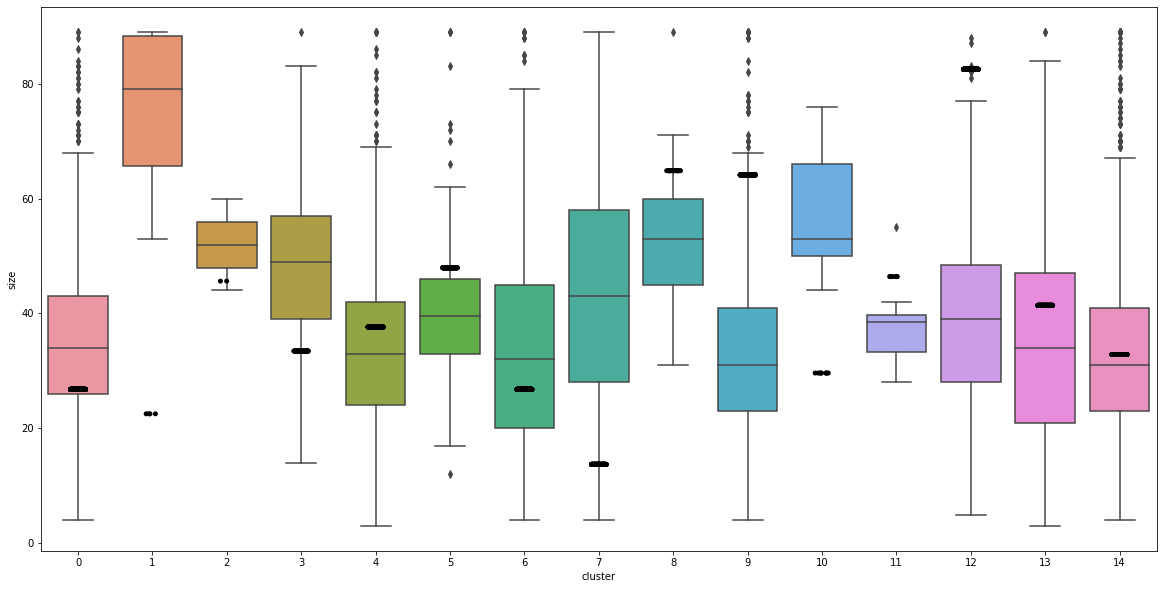

In [68]:
## damm
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': np.array(trS[damm_pred_singlet_label == 0]), 
                   'cluster': damm_pred_singlet_cluster_assig_label})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

In [ ]:
'''
analysisProteins = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
       'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
       'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
       'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
       'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS']

    pretty_printing = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
        'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
        'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
        'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
        'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS', 'size']

    analysisProteins = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19',
                'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin', 'cMyc', 'HER2', 'CD3', 'pHH3', 'ERK',
                'Slug', 'ER', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'CAIX',
                'ECadherin', 'Ki67', 'EGFR', 'pS6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK', 'cPARP-cCasp3',
                'DNA1', 'DNA2']

    pretty_printing = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19',
                'CK8_18', 'Twist', 'CD68', 'CK14', 'SMA', 'Vimentin', 'cMyc', 'HER2', 'CD3', 'pHH3', 'ERK',
                'Slug', 'ER', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'CAIX',
                'ECadherin', 'Ki67', 'EGFR', 'pS6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK', 'cPARP-cCasp3',
                'DNA1', 'DNA2', 'size']
    
    analysisProteins = ['TotalHH3', 'H3K27me3', 'Cytokeratin5', 'Fibronectin',
       'Cytokeratin19', 'Cytokeratin8/18', 'Twist', 'CD68', 'Keratin14', 'SMA',
       'Vimentin', 'cMyc', 'cerbB2_Her2', 'CD3', 'phospho_HH3', 'Erk1/2',
       'Slug', 'RabbitIgGHL', 'Progesterone_Receptor_A/B', 'p53', 'CD44',
       'EpCAM', 'CD45', 'GATA3', 'CD20', 'bCatenin', 'Carbonic_Anhydrase_IX',
       'Ecadherin', 'Ki67', 'EGFR', 'S6', 'Sox9', 'vWF_CD31', 'mTOR',
       'Cytokeratin7', 'panCytokeratin/Keratin_Epithelial',
       'cleavedPARP_CleavedCaspase3', 'DNA1', 'DNA2']

    pretty_printing = ['totHH3', 'H3K27me3', 'CK5', 'Fibronectin', 'CK19', 'CK8_18', 'Twist', 'CD68', 'KK14', 'SMA', 'Vimentin', 'cMyc', 
         'Her2', 'CD3', 'pHH3', 'ERK', 'Slug', 'RabbitIgGHL', 'PR', 'p53', 'CD44', 'EpCAM', 'CD45', 'GATA3',
         'CD20', 'bCatenin', 'CAIX', 'ECadherin', 'Ki67', 'EGFR', 'S6', 'Sox9', 'CD31', 'mTOR', 'CK7', 'panCK',
         'cPARP-cCasp3', 'DNA1', 'DNA2', 'size']
'''